In [1]:
import pickle
from pathlib import Path

import getdist as gd
import getdist.plots as gdplots
import matplotlib.pyplot as plt
import numpy as np

from expconfig import load_config
from sampling.priors import CompoundPrior

In [2]:
OUTPUTS_PATH = Path().resolve().parent / "outputs"


def get_results_dir(n: int = 0) -> Path:
    """Get the most recent results directory.

    Parameters
    ----------
    n : int, optional
        Index of the results directory to retrieve.
        0 for the most recent, 1 for the second most recent, etc.
        Default is 0.

    Returns
    -------
    Path
        Path to the results directory.
    """
    output_dirs = sorted(
        OUTPUTS_PATH.iterdir(), key=lambda p: p.stat().st_mtime, reverse=True
    )
    return output_dirs[n]

In [3]:
RESULTS_DIR = get_results_dir(0)

# cfg = load_config(RESULTS_DIR / "config.yaml")
cfg = load_config(OUTPUTS_PATH.parent / "config.yaml")
prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(500_000, np.random.default_rng(1234))

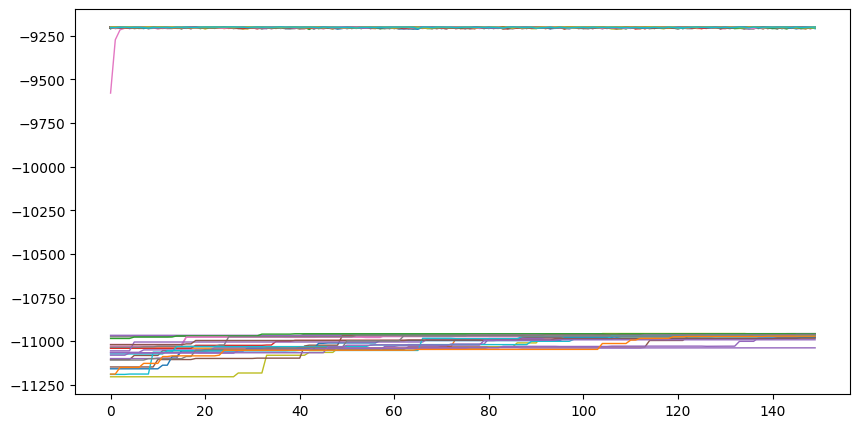

In [6]:
ln_prob = pickle.load(open(RESULTS_DIR / "lnprob_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers
)
samples = pickle.load(open(RESULTS_DIR / "samples_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers, 7
)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

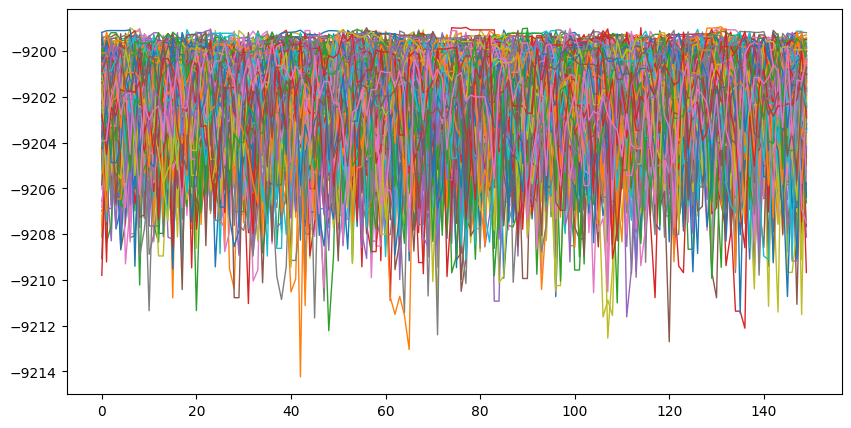

In [7]:
keep_mask = (ln_prob > -9250).all(axis=0)
ln_prob = ln_prob[:, keep_mask]
samples = samples[:, keep_mask, :]

with open(RESULTS_DIR / "lnprob.pkl", "wb") as f:
    pickle.dump(ln_prob.reshape(-1), f)
with open(RESULTS_DIR / "samples.pkl", "wb") as f:
    pickle.dump(samples.reshape(-1, 7), f)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

Removed no burn in
Removed no burn in


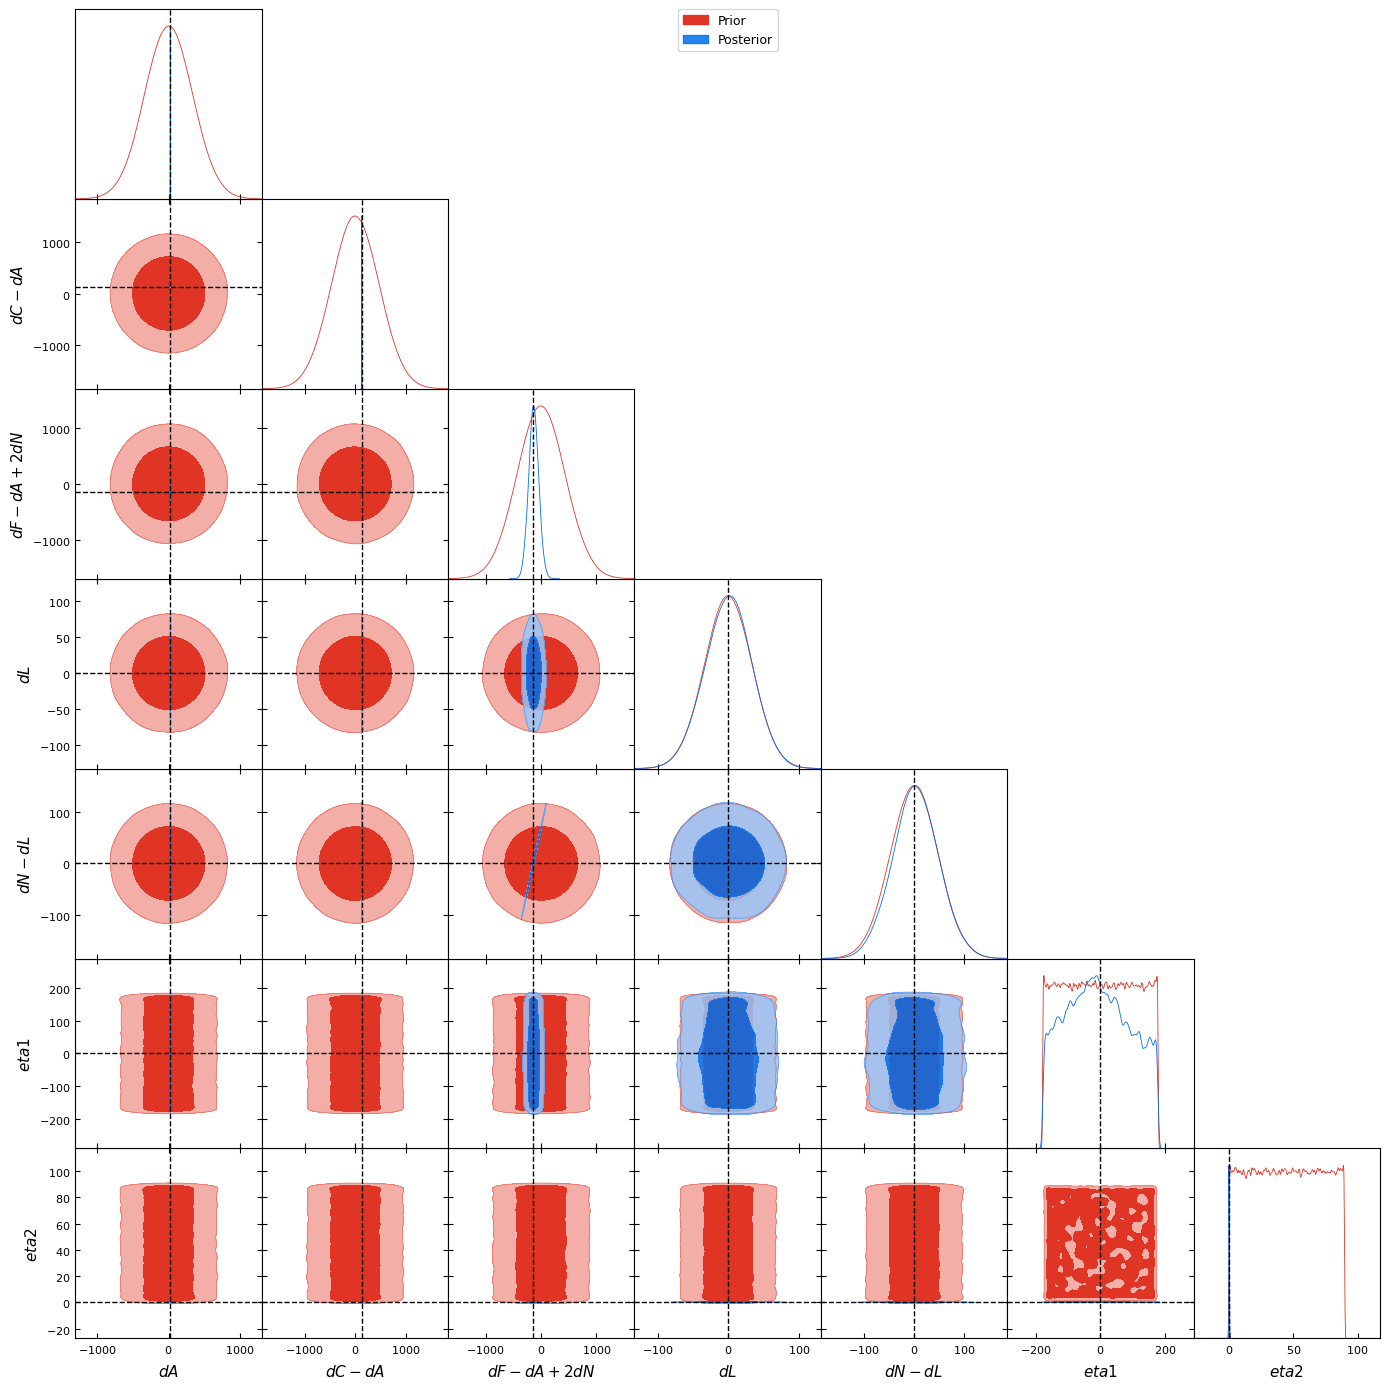

In [8]:
names = ["dA", "dC-dA", "dF-dA+2dN", "dL", "dN-dL", "eta1", "eta2"]
posterior_samples_gd = gd.MCSamples(
    samples=samples.reshape(-1, 7), names=names, labels=names
)
prior_samples_gd = gd.MCSamples(samples=prior_samples, names=names, labels=names)
truth = [
    cfg.truth.A,
    cfg.truth.C - cfg.truth.A,
    cfg.truth.F - cfg.truth.A + 2 * cfg.truth.N,
    cfg.truth.L - cfg.truth.N,
    cfg.truth.N,
    cfg.truth.eta1,
    cfg.truth.eta2,
]
g = gdplots.getSubplotPlotter()
g.triangle_plot(
    [prior_samples_gd, posterior_samples_gd],
    legend_labels=["Prior", "Posterior"],
    filled=True,
    markers=truth,
    marker_args={"color": "k", "lw": 1},
)

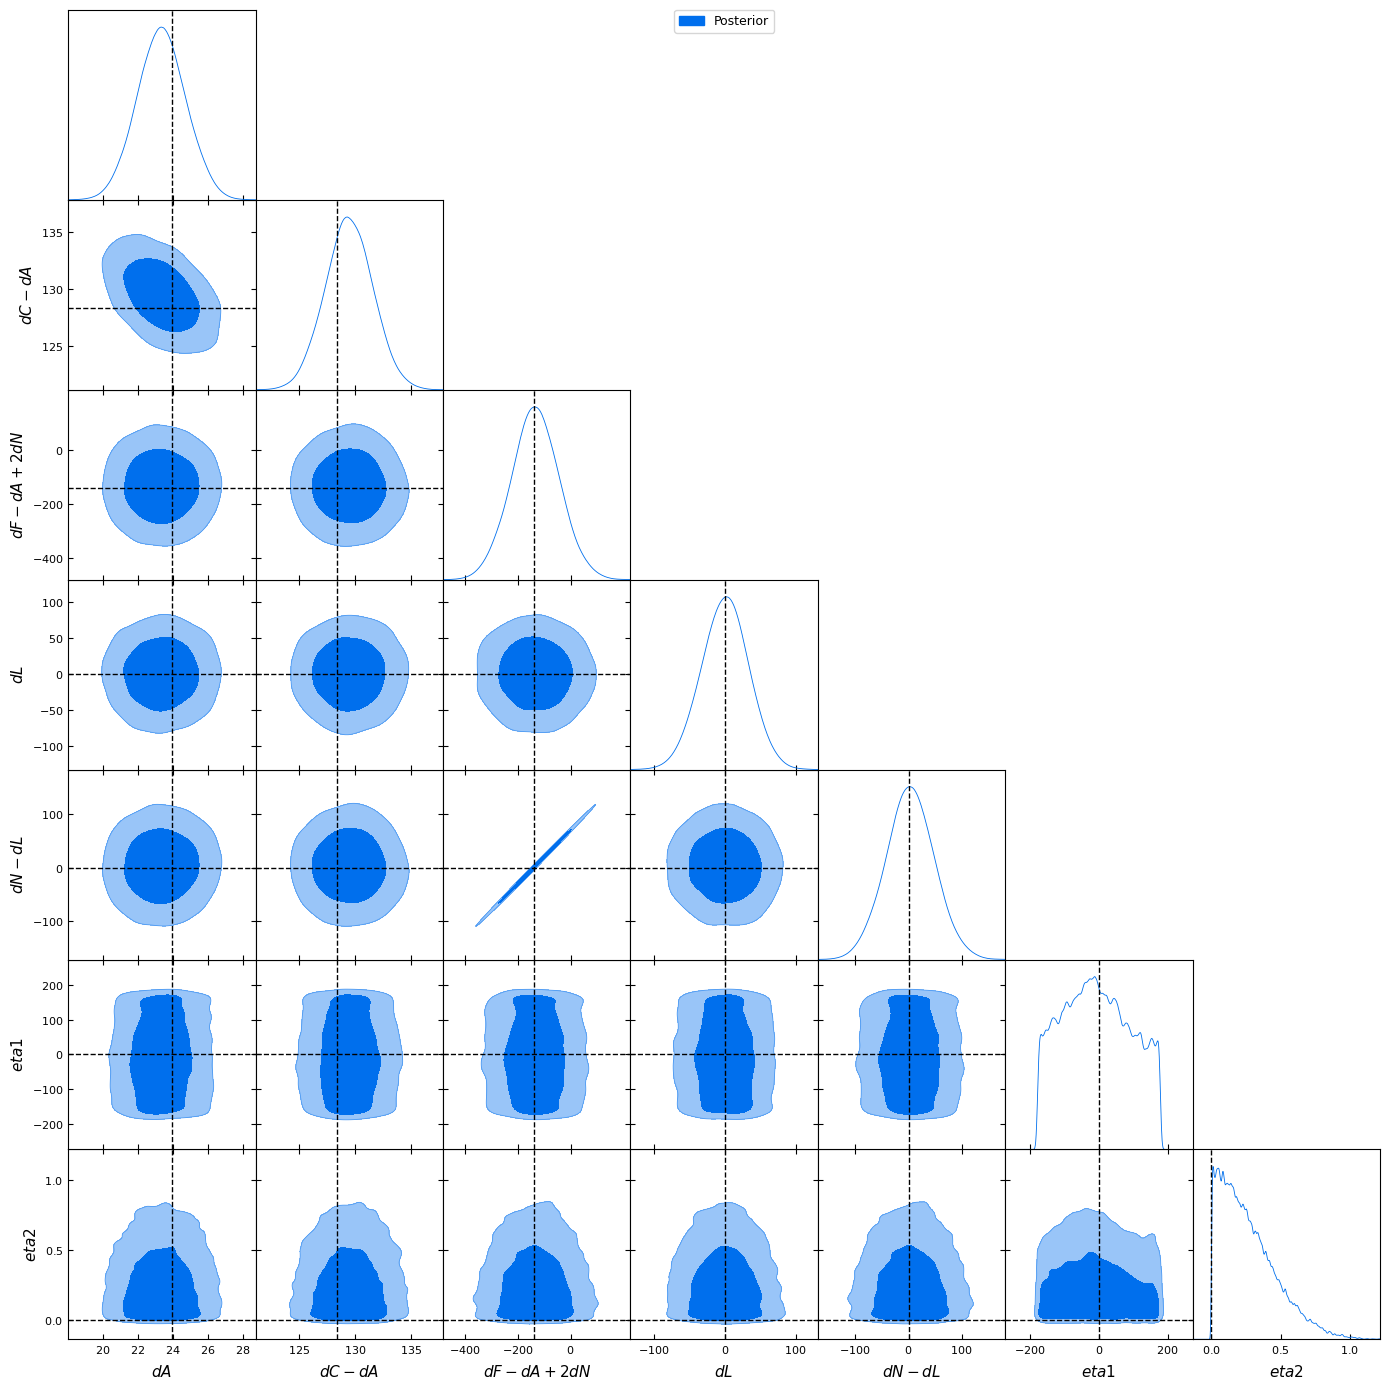

In [9]:
g.triangle_plot(
    [posterior_samples_gd],
    legend_labels=["Posterior"],
    filled=True,
    markers=truth,
    marker_args={"color": "k", "lw": 1},
)